# 1. Setup and Imports

In [2]:
!pip install -q numpy networkx scipy matplotlib qiskit qiskit-aer pylatexenc
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram

# 2. Problem Definition: Max-Cut

Graph for the Max-Cut Problem:


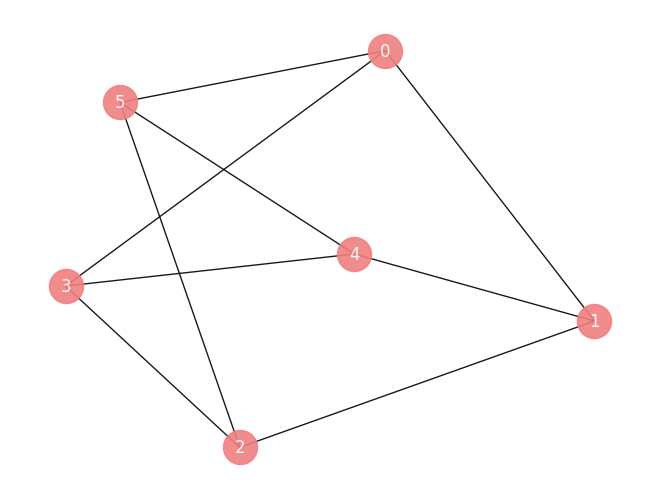

In [3]:
# We'll use a 6-vertex graph for this demonstration.
n_qubits = 6
G = nx.Graph()
G.add_nodes_from(range(n_qubits))
# Define the edges for the graph
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0), (0, 3), (1, 4), (2, 5)]
G.add_edges_from(edges)

print("Graph for the Max-Cut Problem:")
# Draw the graph for visualization
pos = nx.spring_layout(G, seed=42) # for consistent layout
nx.draw(G, pos, with_labels=True, alpha=0.9, node_size=600, node_color='lightcoral', font_color='white')
plt.show()

# 3. QAOA Circuit (Ansatz)

In [4]:
def create_qaoa_circuit(graph, params):
    """
    Creates the QAOA circuit (ansatz).

    Args:
        graph (nx.Graph): The graph defining the Max-Cut problem.
        params (np.array): A flat array of parameters [gamma_1, ..., gamma_p, beta_1, ..., beta_p].

    Returns:
        QuantumCircuit: The parameterized QAOA circuit with measurements.
    """
    p = len(params) // 2  # Number of layers is inferred from the parameters length
    gammas = params[:p]
    betas = params[p:]

    qc = QuantumCircuit(n_qubits)

    # Start in a uniform superposition by applying Hadamard to all qubits
    qc.h(range(n_qubits))

    # Apply p layers of alternating cost and mixer unitaries
    for i in range(p):
        # --- Cost unitary: U_C(gamma) ---
        # This part encodes the problem structure (the edges of the graph).
        qc.barrier()
        for u, v in graph.edges():
            # RZZ gate applies the e^(-i * gamma * Z_u * Z_v) evolution
            qc.rzz(2 * gammas[i], u, v)

        # --- Mixer unitary: U_M(beta) ---
        qc.barrier()
        # RX gate applies the e^(-i * beta * X) evolution to each qubit
        qc.rx(2 * betas[i], range(n_qubits))

    qc.measure_all()
    return qc

# 4. Objective Function & Optimization

In [5]:
def maxcut_cost(bitstring, graph):
    """Calculates the cut size for a given partition (represented by a bitstring)."""
    cut_size = 0
    for u, v in graph.edges():
        if bitstring[u] != bitstring[v]:
            cut_size += 1
    return cut_size

def objective_function(params, graph, sampler):
    """
    The objective function for the classical optimizer.
    It runs the QAOA circuit and returns the negative of the expected cut size.
    """
    # Create the QAOA circuit with the current parameters from the optimizer
    qc = create_qaoa_circuit(graph, params)

    # Run the circuit on the sampler primitive.
    job = sampler.run([qc], shots=10000)
    result = job.result()

    # Since we ran one circuit, we access the first (and only) distribution.
    prob_dist = result.quasi_dists[0].binary_probabilities()

    # Calculate the expected value of the cut size
    expected_value = 0
    for bitstring, probability in prob_dist.items():
        cost = maxcut_cost(bitstring, graph)
        expected_value += probability * cost

    # The optimizer minimizes, so we return the negative of the value we want to maximize.
    return -expected_value

# --- Optimization Execution ---
p = 3  # Number of QAOA layers. More layers can lead to better results.
np.random.seed(42) # Use a seed for reproducibility of random initial parameters
initial_params = np.random.rand(2 * p)

# The Sampler primitive from qiskit-aer is a high-performance simulator
sampler = Sampler()

print(f"\nStarting classical optimization for p = {p} layers...")
# We use the COBYLA optimizer as it's a good choice for noisy, gradient-free optimization.
res = minimize(
    objective_function,
    initial_params,
    args=(G, sampler),
    method='COBYLA'
)

optimal_params = res.x
print("Optimization Complete.")
print(f"Optimal Parameters (gammas and betas): {optimal_params}")
print(f"Maximum Expected Cut (from objective function): {-res.fun:.4f}")


Starting classical optimization for p = 3 layers...
Optimization Complete.
Optimal Parameters (gammas and betas): [-0.2607804   2.07866537 -0.18324942  1.72153366  0.49285286 -0.12965522]
Maximum Expected Cut (from objective function): 7.5248


# 5. Results & Visualization

In [6]:
# ==============================================================================
#  5. RESULTS & VISUALIZATION
# ==============================================================================
# Now, run the QAOA circuit one last time with the optimal parameters found.

print("\nRunning the final circuit with optimal parameters to get the solution distribution...")
final_qc = create_qaoa_circuit(G, optimal_params)

# Run the final circuit
job = sampler.run([final_qc], shots=10000)
result = job.result()
final_dist = result.quasi_dists[0].binary_probabilities()


# Find the most likely bitstring solution from the final distribution
qaoa_solution = max(final_dist, key=final_dist.get)
qaoa_cut = maxcut_cost(qaoa_solution, G)

print(f"\nMost likely QAOA solution: {qaoa_solution}, which corresponds to a cut size of: {qaoa_cut}")

# Plot the probability distribution of all outcomes
plot_histogram(final_dist, title="QAOA Final Solution Distribution", figsize=(12, 7), number_to_keep=10)
plt.show()


Running the final circuit with optimal parameters to get the solution distribution...

Most likely QAOA solution: 010101, which corresponds to a cut size of: 9


# 6. Classical Comparison

In [7]:
def classical_brute_force_solver(graph):
    """Finds the exact max cut by checking every possible partition."""
    n = len(graph.nodes())
    max_cut = 0
    best_partitions = []

    # Iterate through all 2^n possible partitions
    for i in range(2**n):
        # Format the integer as a binary string representing the partition
        # Qiskit's bitstring order is little-endian, so we reverse to match.
        bitstring = format(i, f'0{n}b')[::-1]
        current_cut = maxcut_cost(bitstring, graph)

        if current_cut > max_cut:
            max_cut = current_cut
            best_partitions = [bitstring]
        elif current_cut == max_cut:
            best_partitions.append(bitstring)

    return max_cut, best_partitions

max_cut_classical, classical_solutions = classical_brute_force_solver(G)
print("\n--- Classical Verification ---")
print(f"Exact Max-Cut size (from brute force): {max_cut_classical}")
print(f"Optimal classical partitions: {classical_solutions}")

# --- Final Comparison ---
print("\n--- Final Result ---")
print(f"The QAOA algorithm found a solution with a cut size of {qaoa_cut}.")
if max_cut_classical > 0:
    approximation_ratio = qaoa_cut / max_cut_classical
    print(f"This gives an approximation ratio of: {approximation_ratio:.4f}")
else:
    print("Classical max cut is 0, approximation ratio is not applicable.")

if qaoa_solution in classical_solutions:
    print("Success! The most likely solution found by QAOA is one of the optimal solutions.")
else:
    print("The most likely QAOA solution is not optimal, but may be close.")


--- Classical Verification ---
Exact Max-Cut size (from brute force): 9
Optimal classical partitions: ['101010', '010101']

--- Final Result ---
The QAOA algorithm found a solution with a cut size of 9.
This gives an approximation ratio of: 1.0000
Success! The most likely solution found by QAOA is one of the optimal solutions.
